# UCLA model trained in their original dataset but without visual attributes

This notebook is aimed at training the exact same model we reproduced the results with, but without the aid of the visual attributes for the violence scores regression task

In [2]:
import sys
sys.path.append("../")
sys.path.append("../../venv/lib/python3.6/site-packages/")

In [3]:
from protestDB import cursor
import time
from protestDB import models
from lib import analysis_utils as au
import pandas as pd
import os
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import scipy
from keras import backend as Kbackend
from keras import callbacks as Kcallbacks
from keras import optimizers as Koptimizers
from keras import losses as Klosses
from keras import models as Kmodels
from keras import backend as Kbackend
from keras import applications as Kapplications
from keras import layers as Klayers
import h5py
import itertools
from lib import transforms

/home/jesper/tmp/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Loading up the data

In [4]:
pc = cursor.ProtestCursor()
imgs = pc.getLabelledImagesAndNonProtest(source="UCLA", label_source="UCLA original")
len(imgs)


40720

### Preprocessing

In [5]:
cols = ["name", "label"]
imgs = imgs[cols]
imgs = imgs[~imgs["label"].isna()]
# indx_non_violence = imgs['label'].isnull()
imgs = imgs.rename(columns={"label": "violence"})
imgs

,name,violence
imageHASH,,
030d92ca8d1f4b6b,test-00000.jpg,0.209786
94c4c6443cbc9c14,test-00002.jpg,0.122890
0b2cf29e92aa294f,test-00010.jpg,0.186237
160335f46456562e,test-00013.jpg,0.108334
6a22e2626c464360,test-00020.jpg,0.123604
7864656be2a2260b,test-00028.jpg,0.168648
a494c469ac8e8ec4,test-00029.jpg,0.190641
94d0f7b39ebce000,test-00030.jpg,0.108105
195acace4e4b65c4,test-00037.jpg,0.187670


In [7]:
# Apply a cut point and normalize violence scores
cutpoint = 0.43

#clips
imgs = au.clipDFColumn(imgs, 'violence', cutpoint)

# normalize
imgs = au.minMax(imgs, 'violence')

# mask values that did not had violence labels
# imgs.loc[indx_non_violence, "violence"] = -1

df = imgs
df

,name,violence
imageHASH,,
030d92ca8d1f4b6b,test-00000.jpg,1.000000
94c4c6443cbc9c14,test-00002.jpg,0.664627
0b2cf29e92aa294f,test-00010.jpg,1.000000
160335f46456562e,test-00013.jpg,0.585908
6a22e2626c464360,test-00020.jpg,0.668489
7864656be2a2260b,test-00028.jpg,0.912104
a494c469ac8e8ec4,test-00029.jpg,1.000000
94d0f7b39ebce000,test-00030.jpg,0.584667
195acace4e4b65c4,test-00037.jpg,1.000000


### Divide the data

In [8]:
n_folds = 5
seed = 300

In [9]:
# k_folds = au.getKSplitsStratified(df, n_folds, "protest", seed )
k_folds = au.getKSplits(df, n_folds, seed )

# for i in k_folds:
#     print("kfold has ", len(i[i["protest"] == True]), "protest images and ", len(i[i["protest"] == False]), "non protest images")

In [10]:
# print first fold
k_folds[0]

,name,violence
imageHASH,,
b75c99623a6bcad9,train-17160.jpg,0.960079
7f3cac0ed29624aa,train-16341.jpg,1.000000
b639999581091513,train-12964.jpg,0.519853
397850f6e4caca2e,train-07695.jpg,0.640524
ecbdf0e4ed5d3d6d,train-27461.jpg,0.792245
597831a1a769cad2,test-00300.jpg,0.864091
80a6c69207060b09,train-19425.jpg,1.000000
de7a72664cc43624,test-07460.jpg,1.000000
478120a040cdb434,train-08125.jpg,0.806915


In [11]:
validation_df = k_folds[0].copy()
test_df = k_folds[1].copy()
train_df = k_folds[2].copy().append(k_folds[3].copy()).append(k_folds[4].copy())
print("train set has ", len(train_df) , " images. validation has ", len(validation_df), " images and test has ", len(test_df))

train set has  6988  images. validation has  2329  images and test has  2329


In [12]:
batch_size = 32

In [13]:

dummy_test_generator = au.ResizeSequence(
    train_df[np.random.randint(100):np.random.randint(100, 200)],
    batch_size, 
    targets = ['violence'],
    transforms = [
        transforms.randomResizedCrop,
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalizeMinMax,
        transforms.lighting,
        transforms.normalizeStandardScore
    ] 
)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


violence has shape (32,)


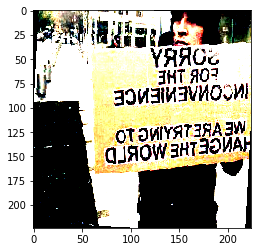

In [14]:
first = next(dummy_test_generator.__iter__())
image = first[0][0]
# protest = first[1][0]
violence = first[1][0]
img = np.array(image)
plt.imshow(img)
# print("protest has shape", protest.shape, " violence has shape", violence.shape)
print("violence has shape", violence.shape)

In [15]:
mask_value = -1; lr = 0.01; momentum = 0.9; epochs = 100; patience = 10

In [16]:
hyper_params_name = "momentum-{}_batch_size-{}_n_folds-{}_n_folds_seed-{}".format(momentum, batch_size, n_folds,seed)
hyper_params_name

'momentum-0.9_batch_size-32_n_folds-5_n_folds_seed-300'

In [18]:
# COMMENT THIS OUT FOR RUN WITH THE WHOLE DATA SET
# size_sample = 34
# validation_df = validation_df[:34]
# test_df = test_df[:34]
# train_df = train_df[:34]
# batch_size = 8
# epochs = 1
# patience = 0

In [19]:
train_generator = au.ResizeSequence(
    train_df,
    batch_size, 
    targets = ['violence'],
    transforms = [
        transforms.randomResizedCrop,
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalizeMinMax,
        transforms.lighting,
        transforms.normalizeStandardScore
    ]
)
validation_generator = au.ResizeSequence(
    validation_df,
    batch_size, 
    targets = ['violence'],
    transforms = [
        transforms.resize,
        transforms.centerCrop,
        transforms.normalizeMinMax,
        transforms.normalizeStandardScore
    ]
)

test_generator = au.ResizeSequence(
    test_df,
    batch_size, 
    targets = ['violence'],
    transforms = [
        transforms.resize,
        transforms.centerCrop,
        transforms.normalizeMinMax,
        transforms.normalizeStandardScore
    ]
)



# Modeling start
Kbackend.clear_session()

img_input = Klayers.Input(shape=(224,224,3), name='img_input')

resnet_model = Kapplications.ResNet50(include_top=False, weights = 'imagenet') (img_input)

flatten = Klayers.Flatten()(resnet_model)

# protest_out = Klayers.Dense(1, activation='sigmoid', name='protest_out')(flatten)
violence_out = Klayers.Dense(1, activation='sigmoid', name='violence_out')(flatten)

model = Kmodels.Model(inputs= img_input, outputs=violence_out)

optimizer = Koptimizers.SGD(lr=lr, momentum=momentum, nesterov=False)
model.compile(optimizer=optimizer,
            loss=Klosses.mean_squared_error,
#           loss=au.buildMaskedLoss(Klosses.mean_squared_error, mask_value),
#           loss_weights={'protest_out': 1., 
#                         'violence_out': 10 }
             )
model.summary()

try:
    __file__ # Apparently, this is not defined in the notebook,
         # but it will be when we start running on the server
         # (So when things gets real)
except NameError:
    __file__ = "test"


name = au.getExperimentName(__file__, len(df), epochs, lr, hyper_params_name)
csv_results = "models_preds/%s.csv" % name
model_checkout_path = "models/%s.hdf5" % name
csv_logger_path = "logs/%s.csv" % name
tensor_board_folder = os.path.join("logs", name)

if not os.path.exists(tensor_board_folder):
    os.makedirs(tensor_board_folder)

if not os.path.exists(tensor_board_folder):
    os.makedirs("logs")

if not os.path.exists(tensor_board_folder):
    os.makedirs("models")

if not os.path.exists(tensor_board_folder):
    os.makedirs("models_preds")

print("Writing model to: \t%s" % model_checkout_path)
print("Writing log to: \t%s\n" % csv_logger_path)



# callbacks
change_lr = Kcallbacks.LearningRateScheduler(
    au.lrUpdateUCLA, 
    verbose = True
)

checkpoint = Kcallbacks.ModelCheckpoint(
    model_checkout_path,
    monitor='val_loss', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1
)

earlystop = Kcallbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0, 
    patience=patience,
    verbose=1, 
    mode='auto'
)

tensor_board = Kcallbacks.TensorBoard(
    log_dir=tensor_board_folder,
     histogram_freq=0,
     batch_size=32, 
     write_graph=True,
     write_grads=False, 
     write_images=False, 
     embeddings_freq=0,
     embeddings_layer_names=None,
     embeddings_metadata=None
)

csv_logger = Kcallbacks.CSVLogger(
    csv_logger_path, 
    separator=',', 
    append=False
)

history = model.fit_generator(
    train_generator,
    validation_data= validation_generator,
    epochs=epochs,
    callbacks = [change_lr, checkpoint, tensor_board, csv_logger, earlystop]
)


# Preds

#load the weights from the best model
model.load_weights(model_checkout_path)

preds = model.predict_generator(test_generator, verbose = 1)
# preds_protest = preds[0][:len(test_df)] # avoid getting more than the needed
preds_violence = preds[:len(test_df)] 
print("Violence shape is ", preds_violence.shape)
# Creates a panda data frame with the results

test_fold_results = test_df.copy()
# test_fold_results["pred_protest"] = preds_protest
test_fold_results["pred_violence"] = preds_violence

print("saving results")
test_fold_results.to_csv(csv_results)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
violence_out (Dense)         (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
Writing model to: 	models/test_datalen-11646_epochs-1_init_lr-0.01_momentum-0.9_batch_size-32_n_folds-5_n_folds_seed-300.hdf5
Writing log to: 	logs/test_datalen-11646_epochs-1_init_lr-0.01_momentum-0.9_batch_size-32_n_folds-5_n_folds_seed-300.csv

Instructi